<a href="https://colab.research.google.com/github/Chan0226/FaceNet/blob/main/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
import glob 

from PIL import Image, ImageDraw


def get_files(path='./', ext=('.png', '.jpeg', '.jpg')):
    """ Get all image files """
    files = []
    for e in ext:
        files.extend(glob.glob(f'{path}/**/*{e}'))
    files.sort(key=lambda p: (os.path.dirname(p), int(os.path.basename(p).split('.')[0])))
    return files

def to_rgb_and_save(path):
    """ Some of the images may have RGBA mode """
    for p in path:
        img = Image.open(p)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
            img.save(p)

In [4]:
# 경로 설정
ABS_PATH = '/content/drive/MyDrive/Colab Notebooks/facenet/'
DATA_PATH = os.path.join(ABS_PATH, 'data')
 
TRAIN_DIR = os.path.join(DATA_PATH, 'train_images')
TEST_DIR = os.path.join(DATA_PATH, 'test_images')

ALIGNED_TRAIN_DIR = TRAIN_DIR + '_cropped'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'

In [5]:
from collections import Counter 


# TRAIN_DIR/TEST_DIR path 받기
trainF, testF = get_files(TRAIN_DIR), get_files(TEST_DIR)

# 각 파일별 사진 개수 표시
trainC, testC = Counter(map(os.path.dirname, trainF)), Counter(map(os.path.dirname, testF))
train_total, train_text  = sum(trainC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in trainC.items()])
test_total, test_text  = sum(testC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in testC.items()])

print(f'Train files\n\tpath: {TRAIN_DIR}\n\ttotal number: {train_total}\n{train_text}')
print(f'Train files\n\tpath: {TEST_DIR}\n\ttotal number: {test_total}\n{test_text}')

Train files
	path: /content/drive/MyDrive/Colab Notebooks/facenet/data/train_images
	total number: 76
	- Kroos - 13
	- Marcelo - 14
	- Modric - 13
	- Perez - 12
	- Ramos - 13
	- Zidane - 11
Train files
	path: /content/drive/MyDrive/Colab Notebooks/facenet/data/test_images
	total number: 12
	- Kroos - 2
	- Marcelo - 2
	- Modric - 2
	- Perez - 2
	- Ramos - 2
	- Zidane - 2


In [6]:
# 사진 RGB 컬러로 변경
to_rgb_and_save(trainF), to_rgb_and_save(testF)

(None, None)

In [7]:
from math import ceil 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline 

from matplotlib.patches import Ellipse


def imshow(img, ax, title):  
    ax.imshow(img)
    if title:
        el = Ellipse((2, -1), 0.5, 0.5)
        ax.annotate(title, xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom',
                    bbox=dict(boxstyle="round", fc="0.8"), 
                    arrowprops=dict(arrowstyle="simple", fc="0.6", ec="none", 
                                    patchB=el, connectionstyle="arc3, rad=0.3"))
    ax.set_xticks([]), ax.set_yticks([])

def plot_gallery(images, ncols, nrows, titles=None, title='', figsize=None): 
    if figsize is None: 
        figsize = (18, ncols) if ncols < 10 else (18, 20)  
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.02)

    for i, ax in enumerate(grid): 
        if i == len(images): break 
        imshow(images[i], ax, titles[i] if titles is not None else '')

    # there are some problems with suptitle alignment 
    y_title_pos = grid[0].get_position().get_points()[1][1] - 0.33 / (1 if nrows == 1 else nrows / 3)
    plt.suptitle(title, y=y_title_pos, fontsize=12)

def plot(paths=None, images=None, titles=None, axtitle=True, title='', to_size=(512, 512)): 
    """
    Plot image gallery by passing (paths, title) or (images, titles)
    :param paths: list of image paths
    :param images: list of (PIL.Image | np.array | torch.Tensor) objects 
    :param titles: list of image titles 
    :param bool axtitle: if paths is not None, then axtitle=True leads to use basedir name as titles 
    :param str title: gallery title   
    :param to_size: image resizing size before plot, default (512, 512)
    """

    if paths is not None and len(paths): 
        images = [Image.open(p).resize(to_size) for p in paths]

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        if axtitle: 
              titles = [os.path.dirname(p).split('/')[-1] for p in paths]

        plot_gallery(images, ncols, nrows, titles, title)

    elif images is not None and len(images): 
        if isinstance(images, list): 
            images = np.array(images)

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        # Rescale to [0., 1.]
        if images[0].max() > 1: 
            images /= 255. 

        # if torch.Tensor change axes 
        if not isinstance(images, np.ndarray): 
            if images.size(1) == 3 or 1: 
                images = images.permute((0, 2, 3, 1))

        plot_gallery(images, ncols, nrows, titles, title)


    else: 
        raise LookupError('You didnt pass any path or image objects')
    plt.show()

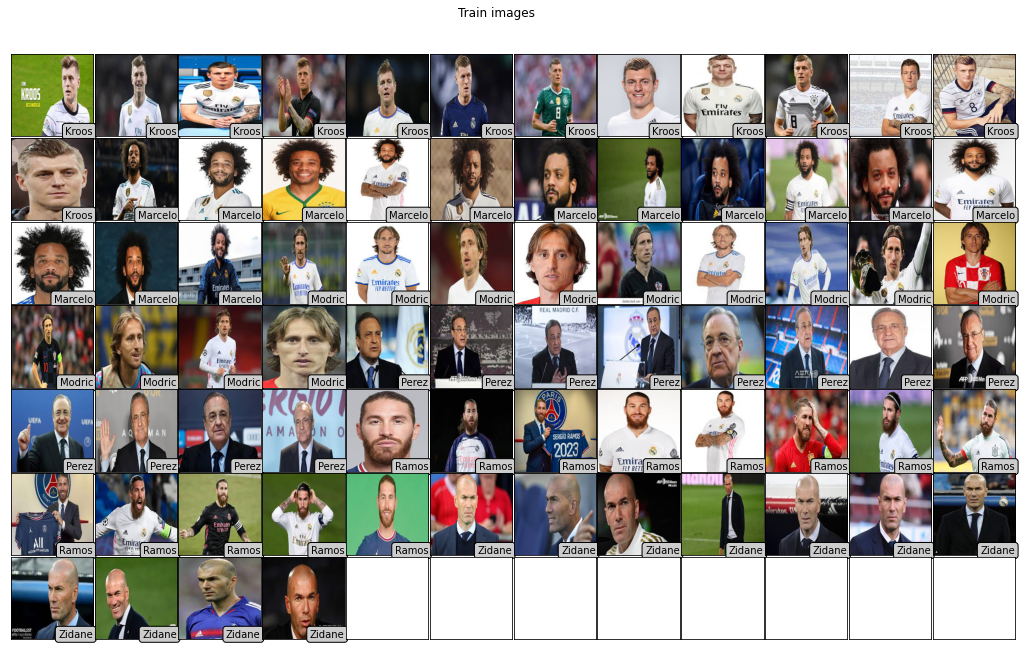

In [8]:
# Train 이미지 
plot(paths=trainF, title='Train images')

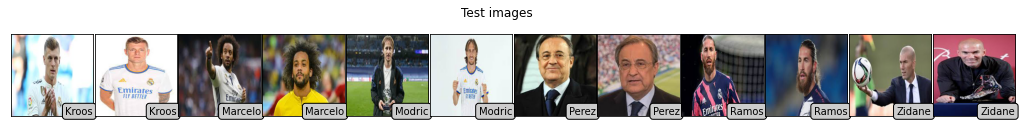

In [9]:
# Test 이미지
plot(paths=testF, title='Test images')

In [10]:
# FaceNet 패키지 이용 (MTCNN,... 등등)
# MTCNN : 얼굴 추출 사용 라이브러리
# 얼굴 추출 라이브러리 비교 https://ichi.pro/ko/facenet-kerasleul-sayonghayeo-eolgul-insig-model-eul-mandeuneun-bangbeob-eun-mueos-ibnikka-278613466321649

!pip install facenet-pytorch 

from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization

     |████████████████████████████████| 1.9 MB 11.8 MB/s 


In [11]:
# 진행 상태 표시 tqdm
import tqdm 

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np

import shutil

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')


def crop_face_and_save(path, new_path=None, model=MTCNN, transformer=None, params=None):
    """
    Detect face on each image, crop them and save to "new_path"
    :param str path: path with images will be passed to  datasets.ImageFolder
    :param str new_path: path to locate new "aligned" images, if new_path is None 
                     then new_path will be path + "_cropped" 
    :param model: model to detect faces, default MTCNN  
    :param transformer: transformer object will be passed to ImageFolder
    :param params: parameters of MTCNN model   
    """
    if not new_path: 
        new_path = path + '_cropped'    
    # if MTCNN 모델 오류 
    if os.path.exists(new_path):      
      shutil.rmtree(new_path)

    # MTCNN 기본 파라미터
    if not params:
        params = {
            'image_size': 160, 'margin': 0, 
            'min_face_size': 10, 'thresholds': [0.6, 0.7, 0.7],
            'factor': 0.709, 'post_process': False, 'device': device
            }
    
    model = model(**params)    
    if not transformer:
        transformer = transforms.Lambda(
            lambd=lambda x: x.resize((1280, 1280)) if (np.array(x) > 2000).all() else x
        )    
    print(transformer)
    # file path 대신 ImageFolder를 이용해서 편리하게 사용 
    dataset = datasets.ImageFolder(path, transform=transformer)    
    dataset.samples = [(p, p.replace(path, new_path)) for p, _ in dataset.samples]    

    # batch size 1 as long as we havent exact image size and MTCNN will raise an error    
    loader = DataLoader(dataset, batch_size=1, collate_fn=training.collate_pil)    
    for i, (x, y) in enumerate(tqdm.tqdm(loader)): 
        model(x, save_path=y)    
    # 메모리 여유
    del model, loader, dataset 

Running on device: cuda:0


In [12]:
# train data 이미지 얼굴 추출 및 저장하기
print('\t- Train data')

crop_face_and_save(TRAIN_DIR, ALIGNED_TRAIN_DIR)

# 저장할 때 빠진 데이터가 없는 지 확인
train_files, train_aligned_files = get_files(TRAIN_DIR), get_files(ALIGNED_TRAIN_DIR)
if len(train_files) != len(train_aligned_files): 
    files = set(map(lambda fp: os.path.relpath(fp, start=TRAIN_DIR), train_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TRAIN_DIR), train_aligned_files))
    detect_failed_train_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

# -------------                     -------------

# test data 이미지 얼굴 추출 
print('\t- Test data')
crop_face_and_save(TEST_DIR, ALIGNED_TEST_DIR)

# 저장할 때 빠진 데이터가 없는 지 확인
test_files, test_aligned_files = get_files(TEST_DIR), get_files(ALIGNED_TEST_DIR)
if len(test_files) != len(test_aligned_files): 
    files = set(map(lambda fp: os.path.relpath(fp, start=TEST_DIR), test_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TEST_DIR), test_aligned_files))
    detect_failed_test_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

	- Train data
Lambda()


100%|██████████| 76/76 [00:05<00:00, 14.49it/s]


	- Test data
Lambda()


100%|██████████| 12/12 [00:00<00:00, 15.18it/s]


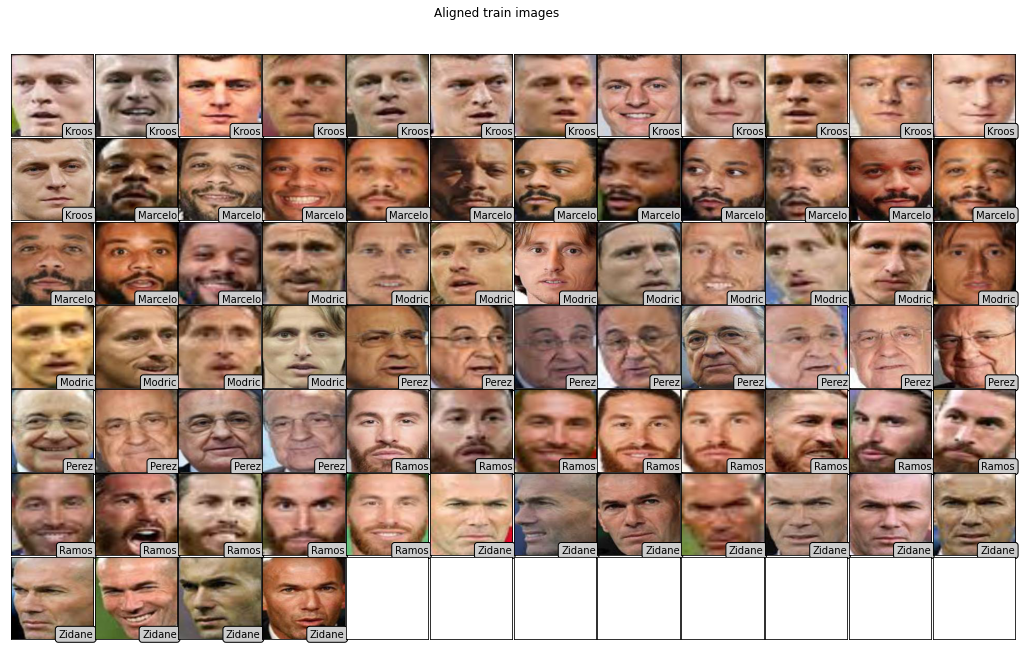

In [13]:
# train data 얼굴만 추출
trainF = get_files(ALIGNED_TRAIN_DIR)
plot(paths=trainF, title='Aligned train images')

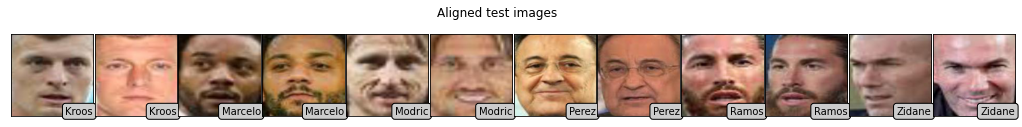

In [14]:
# test data 얼굴만 추출
testF = get_files(ALIGNED_TEST_DIR)
plot(paths=testF, title='Aligned test images')

In [16]:
!pip install albumentations

import albumentations as A

     |████████████████████████████████| 631 kB 12.7 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=c6c62b8d3810eef8fabd4e31fab7ea99d204f21198dfed5139eab402cd3d60e9
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [17]:
from facenet_pytorch import fixed_image_standardization

standard_transform = transforms.Compose([
                                np.float32, 
                                transforms.ToTensor(),
                                fixed_image_standardization
])



aug_mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.15),
                   A.RandomContrast(limit=0.5, p=0.4),
                   A.Rotate(30, p=0.2),
                   A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.OneOrOther(A.JpegCompression(p=0.2), A.Blur(p=0.2), p=0.66),
                   A.OneOf([
                            A.Rotate(45, p=0.3),
                            A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            ], p=0.5),
                  A.HueSaturationValue(val_shift_limit=10, p=0.3)
], p=1)

transform = {
    'train': transforms.Compose([
                                 transforms.Lambda(lambd=lambda x: aug_mask(image=np.array(x))['image']),
                                 standard_transform
    ]),
    'test': standard_transform
}

In [18]:
from torch.utils.data import SubsetRandomSampler


b = 32

# Original train 이미지
print('ALIGNED_TRAIN_DIR = ',ALIGNED_TRAIN_DIR)
print('ALIGNED_TRAIN_DIR = ',ALIGNED_TEST_DIR)
trainD = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=standard_transform)

# Augmented train 이미지 
trainD_aug = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])                                  
# Train Loader
trainL = DataLoader(trainD, batch_size=b, num_workers=2) # x: torch.Size([batch_size, 3, 160, 160]), y: torch.Size([batch_size])


trainL_aug = DataLoader(trainD_aug, batch_size=b, num_workers=2)

# Original test 이미지 
testD = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=standard_transform)
# Test Loader
testL = DataLoader(testD, batch_size=b, num_workers=2)


# 이름 클래스들로 변경
IDX_TO_CLASS = np.array(list(trainD.class_to_idx.keys()))
CLASS_TO_IDX = dict(trainD.class_to_idx.items())

ALIGNED_TRAIN_DIR =  /content/drive/MyDrive/Colab Notebooks/facenet/data/train_images_cropped
ALIGNED_TRAIN_DIR =  /content/drive/MyDrive/Colab Notebooks/facenet/data/test_images_cropped


In [20]:
b = 108
trainD = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=standard_transform)
trainL = DataLoader(trainD, batch_size=b, num_workers=2)
        #  DataLoader(trainD_aug, batch_size=b, num_workers=2)
testD = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=standard_transform)
testL = DataLoader(testD, batch_size=b, num_workers=2)

In [22]:
# facenet의 InceptionResnetV1 모듈 불러오기
from facenet_pytorch import InceptionResnetV1
# model에 InceptionResnetV1 할당 (vggface로 pretrained)
model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [23]:
def fixed_denormalize(image): 
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

from datetime import datetime
def getEmbeds(model, n, loader, imshow=False, n_img=6):
    model.eval()
    # 보여줄 이미지
    images = []

    embeds, labels = [], []    
    print(datetime.now())
    np.random.seed(int(datetime.utcnow().timestamp()))
    for n_i in tqdm.trange(n): 
        for i, (x, y) in enumerate(loader, 1): 

            # # on each first batch get 'n_img' images  
            # if imshow and i == 1: 
            #     inds = np.random.choice(x.size(0), min(x.size(0), n_img))
            #     print("*************",inds)
            #     images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

            embed = model(x.to(device))
            embed = embed.data.cpu().numpy()
            embeds.append(embed), labels.extend(y.data.cpu().numpy())

    if imshow: 
        plot(images=np.concatenate(images))

    return np.concatenate(embeds), np.array(labels)

In [25]:
# 임베딩하기
# Train embeddings 
trainEmbeds, trainLabels = getEmbeds(model, 50, trainL, False)
trainEmbeds_aug, trainLabels_aug = getEmbeds(model, 50, trainL_aug, imshow=False)#

2022-01-11 11:42:38.978773


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


2022-01-11 11:43:09.499897


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


In [26]:
trainEmbeds = np.concatenate([trainEmbeds, trainEmbeds_aug])
trainLabels = np.concatenate([trainLabels, trainLabels_aug])

In [27]:
# Test embeddings 
testEmbeds, testLabels = getEmbeds(model, 1, testL, False)

2022-01-11 11:43:50.474733


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


In [31]:
# 임베딩 npz 파일로 저장
TRAIN_EMBEDS = os.path.join(DATA_PATH, 'trainEmbeds.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, 'testEmbeds.npz')

np.savez(TRAIN_EMBEDS, x=trainEmbeds, y=trainLabels)
np.savez(TEST_EMBEDS, x=testEmbeds, y=testLabels)

# 임베딩된 npz 파일 불러오기
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()

# 이름 라벨링
trainLabels, testLabels = IDX_TO_CLASS[trainLabels], IDX_TO_CLASS[testLabels]

In [32]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns 
sns.set()

def getDist(x, metric='euclidean', index=None, columns=None):
    dists = pairwise_distances(x, x, metric=metric)
    return pd.DataFrame(dists, index=index, columns=columns)

def heatmap(x, title='', cmap='Greens', linewidth=1):
    plt.figure(figsize=(17, 12))
    plt.title(title)
    sns.heatmap(x, cmap=cmap, square=True)
    plt.show()

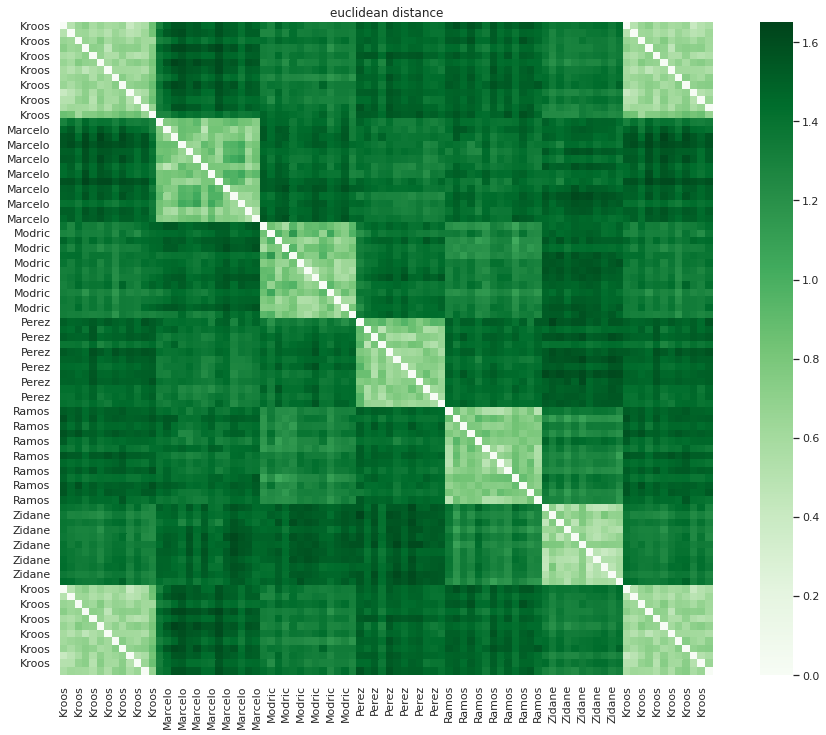

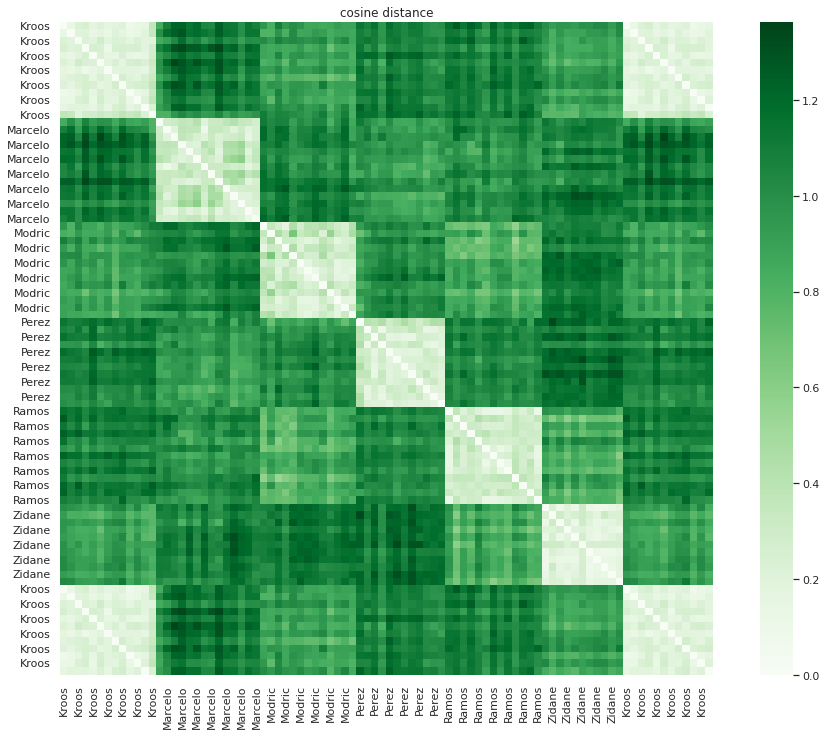

In [33]:
# Note 88 first images are original and 4247 are augmented
# as long as to calculate (4335, 512) distance matrix is time consuming we get only distances of originals 
inds = range(88)

# Train embeddings 
dists = getDist(trainEmbeds[inds], metric='euclidean', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'euclidean distance')

dists = getDist(trainEmbeds[inds], metric='cosine', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'cosine distance')

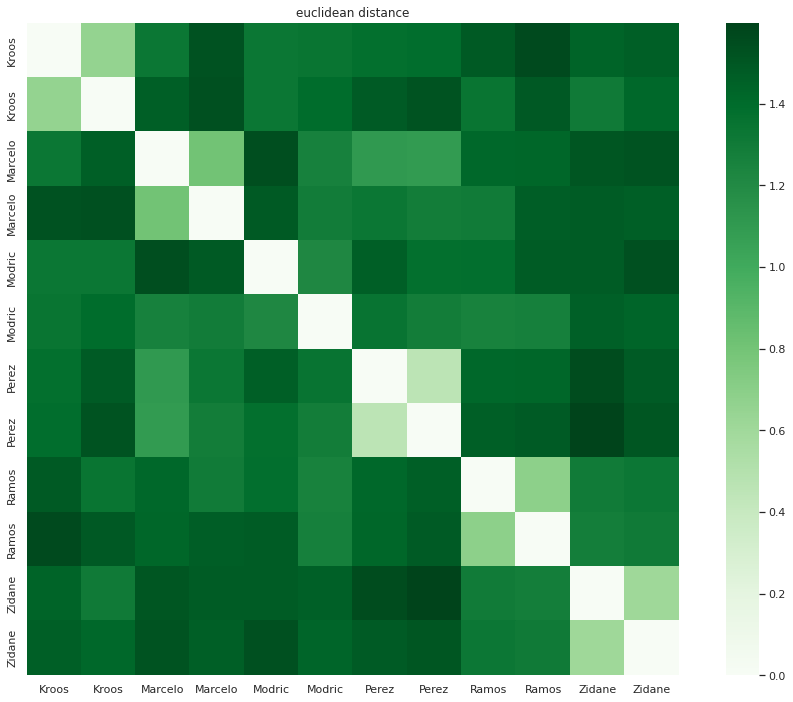

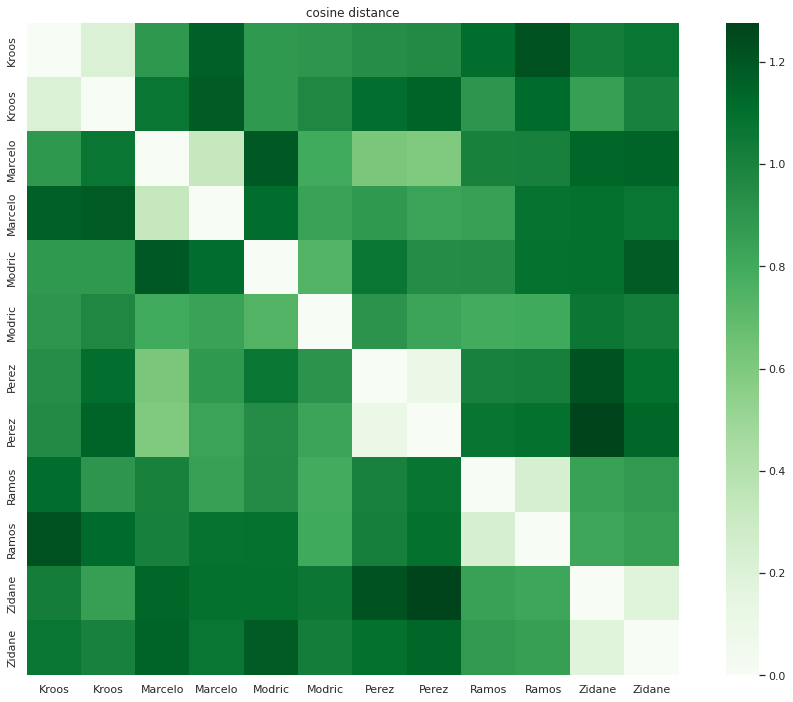

In [34]:
# Test embeddings 
dists = getDist(testEmbeds, metric='euclidean', index=testLabels, columns=testLabels)
heatmap(dists, 'euclidean distance')

dists = getDist(testEmbeds, metric='cosine', index=testLabels, columns=testLabels)
heatmap(dists, 'cosine distance')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


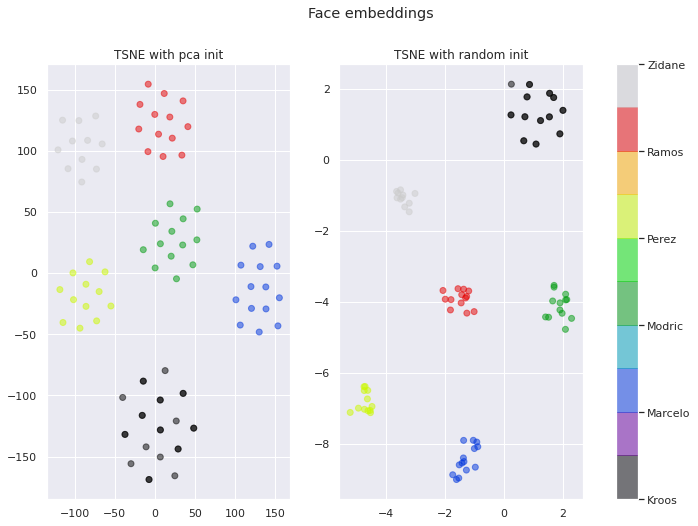

In [35]:
from sklearn.manifold import TSNE


inds = range(88)
X_tsne1 = TSNE(n_components=2, init='pca', random_state=33).fit_transform(trainEmbeds[inds])
X_tsne2 = TSNE(n_components=2, init='random', random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

img = ax[0].scatter(X_tsne1[:, 0], X_tsne1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
ax[1].scatter(X_tsne2[:, 0], X_tsne2[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))

ax[0].set_title('TSNE with pca init')
ax[1].set_title('TSNE with random init')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

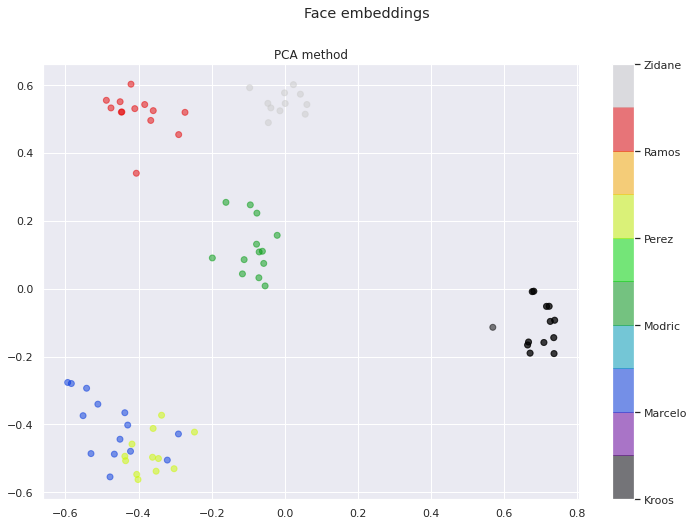

In [36]:
from sklearn.decomposition import PCA


inds = range(88)
X_pca1 = PCA(n_components=2, random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
img = ax.scatter(X_pca1[:, 0], X_pca1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.title('PCA method')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

In [37]:
# data preparation 
X = np.copy(trainEmbeds)
y = np.array([CLASS_TO_IDX[label] for label in trainLabels])

print(f'X train embeds size: {X.shape}')
print(f'Tagret train size: {y.shape}')

X train embeds size: (7600, 512)
Tagret train size: (7600,)


In [38]:
%%time 
# SVC 모델 사용하기 
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings('ignore', 'Solver terminated early.*')
# svc 파라미터
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 'auto'],
              'kernel': ['rbf', 'sigmoid', 'poly']}
model_params = {'class_weight': 'balanced', 'max_iter': 30, 'probability': True, 'random_state': 3}
model = SVC(**model_params)
# GridSearch로 최적의 파라미터 구하기
clf = GridSearchCV(model, param_grid)
clf.fit(X, y)

print('Best estimator: ', clf.best_estimator_)
print('Best params: ', clf.best_params_)

Best estimator:  SVC(C=5000.0, class_weight='balanced', gamma=0.1, kernel='poly', max_iter=30,
    probability=True, random_state=3)
Best params:  {'C': 5000.0, 'gamma': 0.1, 'kernel': 'poly'}
CPU times: user 27min 10s, sys: 2.43 s, total: 27min 12s
Wall time: 27min 3s


In [39]:
print(type(clf))
print(type(clf.best_estimator_))
# 모델에 최적의 파라미터 적용
clf = clf.best_estimator_

<class 'sklearn.model_selection._search.GridSearchCV'>
<class 'sklearn.svm._classes.SVC'>


In [40]:
import joblib as joblib

In [41]:
SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
joblib.dump(clf, SVM_PATH)
clf = joblib.load(SVM_PATH)

In [42]:
# test data 준비
X_test, y_test = np.copy(testEmbeds), np.array([CLASS_TO_IDX[label] for label in testLabels])
print(f'X train embeds size: {X_test.shape}')
print(f'Tagret train size: {y_test.shape}')

X train embeds size: (12, 512)
Tagret train size: (12,)


In [43]:
# 정확도 측정하기
from sklearn.metrics import accuracy_score

inds = range(88)
train_acc = accuracy_score(clf.predict(X[inds]), y[inds])
print(f'Accuracy score on train data: {train_acc:.3f}')

test_acc = accuracy_score(clf.predict(X_test), y_test)
print(f'Accuracy score on test data: {test_acc}')

Accuracy score on train data: 1.000
Accuracy score on test data: 1.0


In [44]:
# gif 파일 전환 함수 설정
import imageio

def toGif(path, dim): 
    gpath = ''.join(path.split('.')[:-1]) + '.gif' 

    with imageio.get_writer(gpath, mode='I') as writer:
        frames = []
        capture = cv2.VideoCapture(path)
    
        i = 0 
        while True: 
            ret, frame = capture.read()
            if not ret: break 

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            writer.append_data(cv2.resize(image, dim))
            i += 1
        print(f'Total frames: {i}')

In [45]:
import cv2

In [46]:
# 비디오를 Gif로 변환
VIDEO_PATH = os.path.join(DATA_PATH, 'video/')
width, height = 640, 360

mov1 = os.path.join(VIDEO_PATH, '1.mp4')
toGif(mov1, (width, height))

Total frames: 151


In [47]:
def diag(x1, y1, x2, y2):
    return np.linalg.norm([x2 - x1, y2 - y1])


def square(x1, y1, x2, y2):
    return abs(x2 - x1) * abs(y2 - y1)


def isOverlap(rect1, rect2):
    x1, x2 = rect1[0], rect1[2]
    y1, y2 = rect1[1], rect1[3]

    x1_, x2_ = rect2[0], rect2[2]
    y1_, y2_ = rect2[1], rect2[3]

    if x1 > x2_ or x2 < x1_: return False 
    if y1 > y2_ or y2 < y1_: return False
  
    rght, lft = x1 < x1_ < x2, x1_ < x1 < x2_
    d1, d2 = 0, diag(x1_, y1_, x2_, y2_)
    threshold = 0.5

    if rght and y1 < y1_: d1 = diag(x1_, y1_, x2, y2)
    elif rght and y1 > y1_: d1 = diag(x1_, y2_, x2, y1)
    elif lft and y1 < y1_: d1 = diag(x2_, y1_, x1, y2) 
    elif lft and y1 > y1_: d1 = diag(x2_, y2_, x1, y1)

    if d1 / d2 >= threshold and square(x1, y1, x2, y2) < square(x1_, y1_, x2_, y2_): return True
    return False

def draw_box(draw, boxes, names, probs, min_p=0.89):
    font = ImageFont.truetype(os.path.join(ABS_PATH, 'arial.ttf'), size=22)

    not_overlap_inds = []
    for i in range(len(boxes)): 
        not_overlap = True
        for box2 in boxes: 
            if np.all(boxes[i] == box2): continue 
            not_overlap = not isOverlap(boxes[i], box2)   
            if not not_overlap: break 
        if not_overlap: not_overlap_inds.append(i)

    boxes = [boxes[i] for i in not_overlap_inds] 
    probs = [probs[i] for i in not_overlap_inds]
    for box, name, prob in zip(boxes, names, probs):
        if prob >= min_p: 
            draw.rectangle(box.tolist(), outline=(255, 255, 255), width=5)
            x1, y1, _, _ = box
            text_width, text_height = font.getsize(f'{name}')
            draw.rectangle(((x1, y1 - text_height), (x1 + text_width, y1)), fill='white')
            draw.text((x1, y1 - text_height), f'{name}: {prob:.2f}', (24, 12, 30), font) 
            
    return boxes, probs 

In [48]:
standard_transform = transforms.Compose([
                                transforms.Resize((160, 160)),
                                np.float32, 
                                transforms.ToTensor(),
                                fixed_image_standardization
])

def get_video_embedding(model, x): 
    embeds = model(x.to(device))
    return embeds.detach().cpu().numpy()

def face_extract(model, clf, frame, boxes):
    names, prob = [], []
    if len(boxes):
        x = torch.stack([standard_transform(frame.crop(b)) for b in boxes])
        embeds = get_video_embedding(model, x)
        idx, prob = clf.predict(embeds), clf.predict_proba(embeds).max(axis=1)
        names = [IDX_TO_CLASS[idx_] for idx_ in idx]
    return names, prob 

def preprocess_image(detector, face_extractor, clf, path, transform=None):
    if not transform: transform = lambda x: x.resize((1280, 1280)) if (np.array(x.size) > 2000).all() else x
    capture = Image.open(path).convert('RGB')
    i = 0 
    
    # iframe = Image.fromarray(transform(np.array(capture)))
    iframe = transform(capture)
   
    boxes, probs = detector.detect(iframe)
    if boxes is None: boxes, probs = [], []
    names, prob = face_extract(face_extractor, clf, iframe, boxes)
            
    frame_draw = iframe.copy()
    draw = ImageDraw.Draw(frame_draw)

    boxes, probs = draw_box(draw, boxes, names, probs)
    return frame_draw.resize((620, 480), Image.BILINEAR)


def preprocess_video(detector, face_extractor, clf, path, transform=None, k=3):
    frames = []
    if not transform: transform = lambda x: x.resize((1280, 1280)) if (np.array(x.shape) > 2000).all() else x
    capture = cv2.VideoCapture(path)
    i = 0 
    while True: 
        ret, frame = capture.read()
        if not ret: break 

        iframe = Image.fromarray(transform(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

        if (i + 1) % k: 
            boxes, probs = detector.detect(iframe)
            if boxes is None: boxes, probs = [], []
            names, prob = face_extract(face_extractor, clf, iframe, boxes)
            
        frame_draw = iframe.copy()
        draw = ImageDraw.Draw(frame_draw)

        boxes, probs = draw_box(draw, boxes, names, probs)
        frames.append(frame_draw.resize((620, 480), Image.BILINEAR))
        i += 1
        
    print(f'Total frames: {i}')
    return frames

def framesToGif(frames, path):
    with imageio.get_writer(path, mode='I') as writer:
        for frame in tqdm.tqdm(frames): 
            writer.append_data(np.array(frame))

In [50]:
# 이미지 폰트 (*꼭 지정해줘야함, 안하면 작동 X, arial.ttf 폰트 다운받아서 ABS_PATH에 넣어주면 됨)
from PIL import ImageFont

k = 3 # each k image will be processed by networks

font = ImageFont.truetype(os.path.join(ABS_PATH, 'arial.ttf'), size=22)

mtcnn = MTCNN(keep_all=True, min_face_size=70, device=device)
model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.6, device=device).eval()

In [52]:
#%%time 
# 결과 동영상 1_aug.gif 로 저장
print('Processing mov1: ')
frames = preprocess_video(mtcnn, model, clf, mov1)
mov1_aug = os.path.join(VIDEO_PATH, '1_aug.gif')
framesToGif(frames, mov1_aug)

Processing mov1: 
Total frames: 151


100%|██████████| 151/151 [00:22<00:00,  6.63it/s]
